GCN with Wiki-CS data

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import WikiCS
from torch_geometric.nn import GCNConv

Download dataset

In [ ]:
from torch_geometric.utils import add_self_loops

dataset = WikiCS(root="../data/WikiCS")
data = dataset[0]

edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)   # done in the dataset paper
data.edge_index = edge_index

# out of 20 splits, use 1
# merge stopping split with train -> new split: 35/15/50
train_mask = data.train_mask[:, 0] | data.stopping_mask[:, 0]  # torch.Size([11701])
val_mask   = data.val_mask[:, 0]
#stop_mask  = data.stopping_mask[:, 0]
test_mask   = data.test_mask  # only one

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Basic GCN model

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        #x  = F.dropout(x, p=0.5, training=self.training)    #in the official example
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    if isinstance(out, tuple):  # because quantized model returns out and comm params
        out = out[0]
    
    loss = F.cross_entropy(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)

    if isinstance(out, tuple):  # because quantized model returns out and comm params
        out = out[0]

    pred = out.argmax(dim=-1)

    accs = []
    for mask in [train_mask, val_mask, test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        accs.append(int(correct) / int(mask.sum()))
    return accs  # [train_acc, val_acc, test_acc]


In [ ]:
import random

hidden = 33
output = int(data.y.max().item()+1)
drop = 0.25
epochs = 500
lr = 0.02
weight_decay = 5e-4

def set_seed():
    seed = random.randint(0, 10_000)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(False)   # have to explicitly disable it (tried to enable deterministic but it was trowing an error)

def run_model(ModelClass, data=data, QuantizerClass=None, compress=False):
    quantizer = None
    set_seed()

    if QuantizerClass is not None:
        quantizer = QuantizerClass()
        model = ModelClass(data.num_features, hidden, output, drop, quantizer=quantizer).to(device)
    else:
        model = ModelClass(data.num_features, hidden, output, drop).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0
    best_test_acc = 0

    for epoch in range(epochs):
        data.to(device)
        train(model, optimizer, data)
        train_acc, val_acc, test_acc = test(model, data)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

    if QuantizerClass is not None:
        return (best_val_acc, best_test_acc), quantizer   # for access in comm calculation, one representative quantizer
    
    if compress:
        return model, best_val_acc, best_test_acc

    return best_val_acc, best_test_acc

In [ ]:
def acc_results(results):
    if isinstance(results, tuple) and len(results) == 3:
        val_acc, test_acc, _ = results
    else:
        val_acc, test_acc = results

    print("Accuracy results:")
    print(f"Validation = {val_acc:.4f}, Test = {test_acc:.4f}")

def neigh_size(data, k=None):   # calculate size of neighborhood for each node, limit k when sampling
    
    neigh_count = torch.zeros(data.num_nodes, dtype=torch.int64)
    for target in data.edge_index[1]:
        neigh_count[target] += 1

    if k is not None:
        neigh_count[neigh_count > k] = k

    return neigh_count

def layer_comm(data, feature_dim, quant=None, k=None):    # calculate total communication in one layer; feature_dim = number of features
    total_size = 0
    
    if quant is not None:
        msg_size = feature_dim * quant.feat_size    # use quantized size of feature
        total_size = quant.params_size  # add scale and min size
    else:
        feature_size = data.x.element_size() # size of one element in tensor (feature) in bytes
        msg_size = feature_dim * feature_size   # size of one message one node sends in bytes

    
    total_msg = neigh_size(data, k).sum().item()    # number of messages in one layer
    total_size += msg_size * total_msg

    return total_size

In [ ]:
gcn_results = run_model(GCN)
acc_results(gcn_results)

gcn_total = layer_comm(data, data.x.shape[1])   # input feature size
print(f"Total communication in layer 1: { gcn_total / 1024:.2f} KB = { gcn_total / (1024**2):.2f} MB")

Accuracy results:
Validation = 0.8349, Test = 0.8102
Total communication in layer 1: 519641.02 KB = 507.46 MB


In [ ]:
gcn_l2 = layer_comm(data, feature_dim=hidden)
full_gcn = gcn_total + gcn_l2

print(f"Total communication of basic model through both layers: { full_gcn / 1024:.2f} KB")

Total communication of basic model through both layers: 576801.53 KB


Quantized GCN models

In [ ]:
from abc import ABC, abstractmethod

class Quantizer(ABC):
    def __init__(self):
        self.feat_size = 1   # compress each feature to 1 byte, 8 bits 
        self.min = 0    # min and max possible numbers to code with 8 bits
        self.max = 255

    @abstractmethod
    def _find_minmax(self, x):
        pass

    def quantize(self, x):
        x_min, x_max = self._find_minmax(x)
        scale = (x_max - x_min) / (self.max - self.min) # edge case when max=min ?  + 1e-8
        x_quant = torch.clamp(((x - x_min) / scale).round(), self.min, self.max)
        x_quant = x_quant.to(torch.uint8)   # compress to int
        # calculate size of scale and min which are sent once
        self.params_size = scale.numel() * scale.element_size() + x_min.numel() * x_min.element_size()

        return x_quant, (scale, x_min)  # all of this is part of communication
    
    def dequantize(self, x_quant, params):
        scale, x_min = params
        return x_quant.float() * scale + x_min


In [ ]:
class GlobalQuantizer(Quantizer):
    def _find_minmax(self, x):
        x_min = x.min()
        x_max = x.max()
        return x_min, x_max

In [ ]:
class FeatureQuantizer(Quantizer):
    def _find_minmax(self, x):
        x_min = x.min(dim=0, keepdim=True).values
        x_max = x.max(dim=0, keepdim=True).values
        return x_min, x_max

In [ ]:
class NodeQuantizer(Quantizer):
    def _find_minmax(self, x):
        x_min = x.min(dim=1, keepdim=True).values
        x_max = x.max(dim=1, keepdim=True).values
        return x_min, x_max

In [ ]:
class GCNQuantized(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, quantizer=GlobalQuantizer):
        super().__init__()
        self.quantizer = quantizer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x_quant, params = self.quantizer.quantize(x)
        x = self.quantizer.dequantize(x_quant, params)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x, (x_quant, params)

In [ ]:
q1_results, q1 = run_model(GCNQuantized, data, QuantizerClass=GlobalQuantizer)
acc_results(q1_results)

q1_l1 = layer_comm(data, data.x.shape[1], quant=q1)   # input feature size and quantizer to retrieve sizes
q1_diff = gcn_total - q1_l1

print(f"Total communication in layer 1 using global quantization: { q1_l1 / 1024:.2f} KB")
print(f"Communication lowered by { q1_diff / 1024:.2f} KB compared to the basic model")

# full model comm for the last plot
q1_l2 = gcn_l2  # they have the same communication after the first layer
q1_total = q1_l1 + q1_l2

Accuracy results:
Validation = 0.8372, Test = 0.8103
Total communication in layer 1 using global quantization: 129910.26 KB
Communication lowered by 389730.75 KB compared to the basic model


In [ ]:
q2_results, q2 = run_model(GCNQuantized, data, QuantizerClass=FeatureQuantizer)
acc_results(q2_results)

q2_l1 = layer_comm(data, data.x.shape[1], quant=q2)   # input feature size and quantizer to retrieve sizes
q2_diff = gcn_total - q2_l1

print(f"Total communication in layer 1 using feature quantization: { q2_l1 / 1024:.2f} KB")
print(f"Communication lowered by { q2_diff / 1024:.2f} KB compared to the basic model")

# full model comm for the last plot
q2_l2 = gcn_l2  # they have the same communication after the first layer
q2_total = q2_l1 + q2_l2

Accuracy results:
Validation = 0.8378, Test = 0.8131
Total communication in layer 1 using feature quantization: 129912.60 KB
Communication lowered by 389728.42 KB compared to the basic model


In [ ]:
q3_results, q3 = run_model(GCNQuantized,data, QuantizerClass=NodeQuantizer)
acc_results(q3_results)

q3_l1 = layer_comm(data, data.x.shape[1], quant=q3)   # input feature size and quantizer to retrieve sizes
q3_diff = gcn_total - q3_l1

print(f"Total communication in layer 1 using node quantization: { q3_l1 / 1024:.2f} KB")
print(f"Communication lowered by { q3_diff / 1024:.2f} KB compared to the basic model")

# full model comm for the last plot
q3_l2 = gcn_l2  # they have the same communication after the first layer
q3_total = q3_l1 + q3_l2

Accuracy results:
Validation = 0.8349, Test = 0.8110
Total communication in layer 1 using node quantization: 130001.67 KB
Communication lowered by 389639.35 KB compared to the basic model


Basic GCN model using neighbor sparsification

Min messages per node: 1
Max messages per node: 3325
Mean degree: 37.90
Median degree: 13


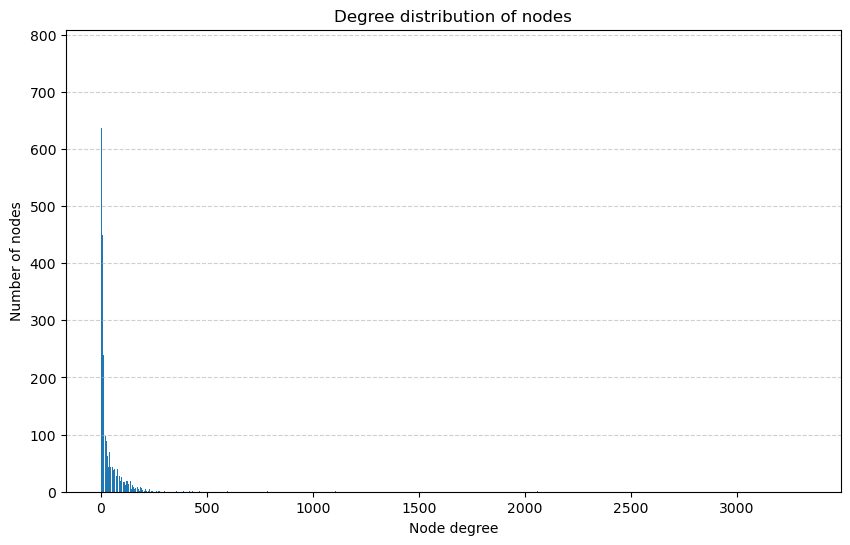

In [ ]:
# insight to node degrees
import matplotlib.pyplot as plt

full_neigh = neigh_size(data)

print("Min messages per node:", full_neigh.min().item())
print("Max messages per node:", full_neigh.max().item())
print(f"Mean degree: {full_neigh.float().mean().item():.2f}")
print(f"Median degree: {full_neigh.median().item()}")   # bcs there are outliers

unique_degrees, counts = torch.unique(full_neigh, return_counts=True) # how many nodes are of each degree

plt.figure(figsize=(10,6))
plt.bar(unique_degrees.numpy(), counts.numpy())
plt.xlabel("Node degree")
plt.ylabel("Number of nodes")
plt.title("Degree distribution of nodes")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

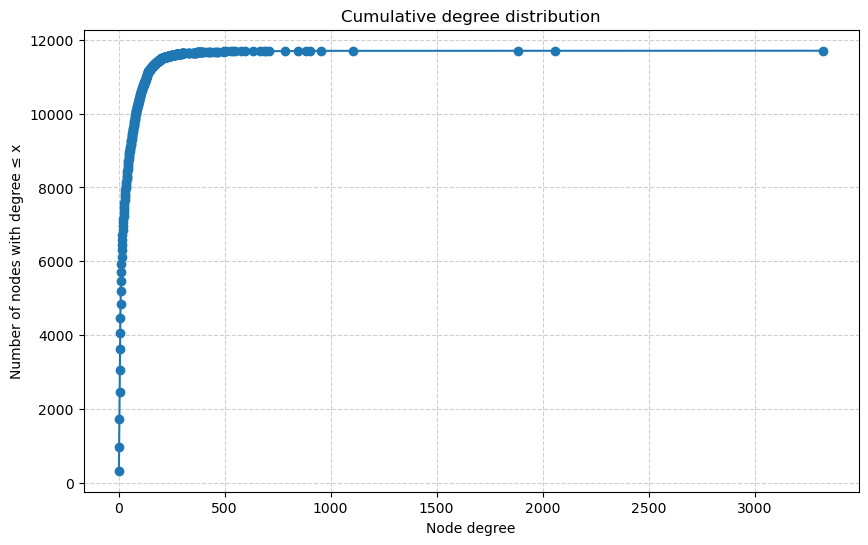

In [ ]:
cumulative_counts = torch.cumsum(counts, dim=0)
plt.figure(figsize=(10,6))
plt.plot(unique_degrees.numpy(), cumulative_counts.numpy(), marker='o')
plt.xlabel("Node degree")
plt.ylabel("Number of nodes with degree ≤ x")
plt.title("Cumulative degree distribution")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
sorted_counts, indices = torch.sort(counts, descending=True)
sorted_degrees = unique_degrees[indices]

torch.unique(full_neigh, return_counts=True)

print("Degrees sorted by highest number of nodes (top 30):")
for deg, cnt in zip(sorted_degrees.tolist()[:25], sorted_counts.tolist()[:25]):
    print(f"Degree {deg}: {cnt} nodes")

Degrees sorted by highest number of nodes (top 30):
Degree 3: 770 nodes
Degree 4: 721 nodes
Degree 2: 636 nodes
Degree 5: 590 nodes
Degree 6: 566 nodes
Degree 7: 449 nodes
Degree 8: 412 nodes
Degree 9: 357 nodes
Degree 10: 354 nodes
Degree 1: 334 nodes
Degree 11: 292 nodes
Degree 12: 240 nodes
Degree 13: 208 nodes
Degree 15: 185 nodes
Degree 14: 181 nodes
Degree 16: 153 nodes
Degree 18: 141 nodes
Degree 17: 134 nodes
Degree 19: 117 nodes
Degree 20: 114 nodes
Degree 22: 104 nodes
Degree 24: 102 nodes
Degree 21: 98 nodes
Degree 27: 93 nodes
Degree 26: 89 nodes


In [ ]:
print("75th percentile degree:", int(torch.quantile(full_neigh.float(), 0.75).item()))
print("90th percentile degree:", int(torch.quantile(full_neigh.float(), 0.9).item()))

Median degree: 13
75th percentile degree: 48
90th percentile degree: 104


In [ ]:
from torch_geometric.loader import NeighborLoader

sampling = [[80,80], [80,50], [50,40]]

sample1 = sampling[0]
# full batch as previously
nl1 = NeighborLoader(data, num_neighbors=sample1, batch_size=data.num_nodes, shuffle=False)
batch1 = next(iter(nl1))

nl1_results = run_model(GCN, data=batch1)
acc_results(nl1_results)

nl1_l1 = layer_comm(data, data.x.shape[1], quant=None, k=sample1[0])
nl1_l2 = layer_comm(data, hidden, quant=None, k=sample1[1])
nl1_total = nl1_l1 + nl1_l2

nl1_diff = full_gcn - nl1_total

print(f"Total communication with sampling sizes {sample1}: { nl1_total / 1024:.2f} KB")
print(f"Communication lowered by { nl1_diff / 1024:.2f} KB compared to the basic model")

Accuracy results:
Validation = 0.8344, Test = 0.8108
Total communication with sampling sizes [80, 80]: 422998.45 KB
Communication lowered by 153803.07 KB compared to the basic model


In [ ]:
sample2 = sampling[1]
# full batch as previously
nl2 = NeighborLoader(data, num_neighbors=sample2, batch_size=data.num_nodes, shuffle=False)
batch2 = next(iter(nl2))

nl2_results = run_model(GCN, data=batch2)
acc_results(nl2_results)

nl2_l1 = layer_comm(data, data.x.shape[1], quant=None, k=sample2[0])
nl2_l2 = layer_comm(data, hidden, quant=None, k=sample2[1])
nl2_total = nl2_l1 + nl2_l2

nl2_diff = full_gcn - nl2_total

print(f"Total communication with sampling sizes {sample2}: { nl2_total / 1024:.2f} KB")
print(f"Communication lowered by { nl2_diff / 1024:.2f} KB compared to the basic model")

Accuracy results:
Validation = 0.8372, Test = 0.8131
Total communication with sampling sizes [80, 50]: 414286.97 KB
Communication lowered by 162514.56 KB compared to the basic model


In [ ]:
sample3 = sampling[2]
# full batch as previously
nl3 = NeighborLoader(data, num_neighbors=sample3, batch_size=data.num_nodes, shuffle=False)
batch3 = next(iter(nl3))

nl3_results = run_model(GCN, data=batch3)
acc_results(nl3_results)

nl3_l1 = layer_comm(data, data.x.shape[1], quant=None, k=sample3[0])
nl3_l2 = layer_comm(data, hidden, quant=None, k=sample3[1])
nl3_total = nl3_l1 + nl3_l2

nl3_diff = full_gcn - nl3_total

print(f"Total communication with sampling sizes {sample3}: { nl3_total / 1024:.2f} KB")
print(f"Communication lowered by { nl3_diff / 1024:.2f} KB compared to the basic model")

Accuracy results:
Validation = 0.8378, Test = 0.8149
Total communication with sampling sizes [50, 40]: 331134.49 KB
Communication lowered by 245667.04 KB compared to the basic model


In [ ]:
from torch_geometric.utils import degree

def topk_edges(data, k):
    source, target = data.edge_index
    deg = degree(source, data.num_nodes)   # deg[i] = number of outgoing edges of node i 

    new_edges = []
    for node in range(data.num_nodes):
        neighbors = target[source == node]
        if len(neighbors) > k:
            neighbors = neighbors[deg[neighbors].argsort(descending=True)[:k]]  # take only top k neighs with highest degrees
        for neigh in neighbors:
            new_edges.append([node, neigh])

    new_edges = torch.tensor(new_edges, dtype=torch.int64).t().contiguous()
    data_topk = data.clone()
    data_topk.edge_index = new_edges
    
    return data_topk

In [ ]:
data_topk1 = topk_edges(data, k=100)
topk1_results = run_model(GCN, data_topk1)
acc_results(topk1_results)


topk1_l1 = layer_comm(data_topk1, data.x.shape[1])
topk1_l2 = layer_comm(data_topk1, hidden)
topk1_total = topk1_l1 + topk1_l2

topk1_diff = full_gcn - topk1_total

print(f"Total communication with sampling top 100 highest degree neighbors: { topk1_total / 1024:.2f} KB")
print(f"Communication lowered by { topk1_diff / 1024:.2f} KB compared to the basic model")

Accuracy results:
Validation = 0.8315, Test = 0.8156
Total communication with sampling top 100 highest degree neighbors: 461391.01 KB
Communication lowered by 115410.52 KB compared to the basic model


In [ ]:
data_topk2 = topk_edges(data, k=48)
topk2_results = run_model(GCN, data_topk2)
acc_results(topk2_results)


topk2_l1 = layer_comm(data_topk2, data.x.shape[1])
topk2_l2 = layer_comm(data_topk2, hidden)
topk2_total = topk2_l1 + topk2_l2

topk2_diff = full_gcn - topk2_total

print(f"Total communication with sampling top 48 highest degree neighbors: { topk2_total / 1024:.2f} KB")
print(f"Communication lowered by { topk2_diff / 1024:.2f} KB compared to the basic model")

Accuracy results:
Validation = 0.8242, Test = 0.8038
Total communication with sampling top 48 highest degree neighbors: 327665.50 KB
Communication lowered by 249136.03 KB compared to the basic model


Basic GCN model using feature sparsification

In [ ]:
# random projection - fast, robust to outliers, but usually used for veeery big dimensions otherwise pca
import math

n = data.x.shape[0] # number of nodes

def random_projection(epsilon, data):
    k = math.ceil(math.log(n) / epsilon**2)
    d = data.x.shape[1]
    R = torch.randn(d, k, device=device)   # Gaussian random projection
    data.x = data.x @ R
    print(f"Random projection: new feature dim = {k}")
    return data

In [ ]:
import copy

epsilon1 = 0.2   # allowed distortion
data_p1 = copy.deepcopy(data)
data_p1 = random_projection(epsilon1, data_p1)

fs1_results = run_model(GCN, data=data_p1)
acc_results(fs1_results)

fs1_l1 = layer_comm(data_p1, data_p1.x.shape[1])
fs1_l2 = layer_comm(data_p1, hidden)
fs1_total = fs1_l1 + fs1_l2

fs1_diff = full_gcn - fs1_total

print(f"Total communication: { fs1_total / 1024:.2f} KB")
print(f"Communication lowered by { fs1_diff / 1024:.2f} KB compared to the basic model")

Random projection: new feature dim = 235
Accuracy results:
Validation = 0.8021, Test = 0.7802
Total communication: 464212.64 KB
Communication lowered by 112588.89 KB compared to the basic model


In [ ]:
epsilon2 = 0.3   # allowed distortion
data_p2 = copy.deepcopy(data)
data_p2 = random_projection(epsilon2, data_p2)

fs2_results = run_model(GCN, data=data_p2)
acc_results(fs2_results)

fs2_l1 = layer_comm(data_p2, data_p2.x.shape[1])
fs2_l2 = layer_comm(data_p2, hidden)
fs2_total = fs2_l1 + fs2_l2

fs2_diff = full_gcn - fs2_total

print(f"Total communication: { fs2_total / 1024:.2f} KB")
print(f"Communication lowered by { fs2_diff / 1024:.2f} KB compared to the basic model")

Random projection: new feature dim = 105
Accuracy results:
Validation = 0.8259, Test = 0.8040
Total communication: 239034.87 KB
Communication lowered by 337766.66 KB compared to the basic model


Basic GCN model with model compression after training

In [ ]:
# dtype of parameters is float32 with dimensions [33], [33,300], [10], [10,33]
# GCN doesn't create buffers so model_size sums only parameters

def model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.numel() * param.element_size()
    
    size = param_size
    return size

def quantize(x):
    qmin = 0
    qmax = 255

    x_min = x.min()
    x_max = x.max()

    scale = (x_max - x_min) / (qmax - qmin) # edge case when max=min ?  + 1e-8

    x_quant = torch.clamp(((x - x_min) / scale).round(), qmin, qmax)
    x_quant = x_quant.to(torch.uint8)   # compress to int
    # calculate size of scale and min which are sent once
    params_size = scale.element_size() + x_min.element_size()

    return x_quant, (scale, x_min), params_size

def dequantize(x_quant, params):
    scale, x_min = params
    return x_quant.float() * scale + x_min

def compress_model1(model):

    model.half()    # dtype is now float16
    size = model_size(model)

    return size

def compress_model2(model):
    size = 0
    parameters = list(model.parameters())   # bias and weights x2

    for param in parameters:
        param_quant, q_params, q_params_size = quantize(param.data) # quantization calculated but not applied
        size += param_quant.numel() * param_quant.element_size()
        size += q_params_size
        # pytorch restriction: parameters can't be int
        # in a real world scenario, save (but not directly in live model, modified torch.save) and send, dequantize at central node

        param.data = dequantize(param_quant, q_params)

    return size

In [ ]:
comp1, val_acc, test_acc = run_model(GCN, data, QuantizerClass=None, compress=True)
comp1_size1 = model_size(comp1)
comp1_size2 = compress_model1(comp1)
data_c1 = copy.deepcopy(data)   # so that original data is intact for next model compression
data_c1.x = data_c1.x.half()  # cast input features to half so there is no type mismatch with weights which are now half
accs = test(comp1, data_c1)    #returns [train_acc, val_acc, test_acc]
comp1_results = [val_acc, accs[2]]

print('Before compression:')
print(f"Model size = {comp1_size1 / 1024:.2f} KB")
print('After compression:')
print(f"Model size = {comp1_size2 / 1024:.2f} KB")
acc_results(comp1_results)
print(f'Size difference = { (comp1_size1 - comp1_size2) / 1024} KB')
print('Accuracy change = ', accs[2] - test_acc)

Before compression:
Model size = 40.13 KB
After compression:
Model size = 20.06 KB
Accuracy results:
Validation = 0.8349, Test = 0.8122
Size difference = 20.064453125 KB
Accuracy change =  -0.0010261672652641662


In [ ]:
comp2, val_acc, test_acc = run_model(GCN, data, QuantizerClass=None, compress=True)
comp2_size1 = model_size(comp2)
comp2_size2 = compress_model2(comp2)
accs = test(comp2, data)    #return accs  # [train_acc, val_acc, test_acc]
comp2_results = [val_acc, accs[2]]

print('Before compression:')
print(f"Model size = {comp2_size1 / 1024} KB")
print('After compression:')
print(f"Model size = {comp2_size2 / 1024} KB")
acc_results(comp2_results)
print(f'Size difference = { (comp2_size1 - comp2_size2) / 1024} KB')
print('Accuracy change = ', accs[2] - test_acc)

Before compression:
Model size = 40.12890625 KB
After compression:
Model size = 10.0634765625 KB
Accuracy results:
Validation = 0.8389, Test = 0.8102
Size difference = 30.0654296875 KB
Accuracy change =  -0.0022233624080725267


Final data comparison

In [ ]:
full_models = ["Basic GCN", "Global quantization", "Feature quantization", "Node quantization",
               "Neighbor sparsification [80,80]", "Neighbor sparsification [80,50]", "Neighbor sparsification [50,40]",
               "Top-k neighbors, k=100", "Top-k neighbors, k=48",
               "Feature sparsification, d=235", "Feature sparsification, d=105"]

accuracies = [gcn_results[1], q1_results[1], q2_results[1], q3_results[1], 
              nl1_results[1], nl2_results[1], nl3_results[1],
              topk1_results[1], topk2_results[1],
              fs1_results[1], fs2_results[1]]

comm_sizes = torch.tensor([full_gcn, q1_total, q2_total, q3_total,
              nl1_total, nl2_total, nl3_total,
              topk1_total, topk2_total,
              fs1_total, fs2_total])

# when printing skip first diff
diff_comm = (full_gcn - comm_sizes) / (1024.0**2)   # MB

In [ ]:
gcn_acc = gcn_results[1]
gcn_comm = full_gcn / (1024.0**2)

for i, model in enumerate(full_models):
    acc = accuracies[i]
    comm = comm_sizes[i]
    diff = diff_comm[i]

    if i==0:
        print(f"----{model}----")
        print(f"Test accuracy = {acc:.4f}")
        print(f"Total communication = {comm / 1024**2:.2f} MB")
        print()
        continue

    print(f"----{model}----")
    print(f"Test accuracy = {acc:.4f} ({-(gcn_acc - acc):.4f})")
    print(f"Total communication = {comm / 1024**2:.2f} MB")
    print(f"Communication lowered by {diff / gcn_comm * 100:.2f} % (-{diff:.2f} MB)")
    print()

----Basic GCN----
Test accuracy = 0.8102
Total communication = 563.28 MB

----Global quantization----
Test accuracy = 0.8146 (0.0044)
Total communication = 182.69 MB
Communication lowered by 67.57 % (-380.60 MB)

----Feature quantization----
Test accuracy = 0.8107 (0.0005)
Total communication = 182.69 MB
Communication lowered by 67.57 % (-380.59 MB)

----Node quantization----
Test accuracy = 0.8126 (0.0024)
Total communication = 182.78 MB
Communication lowered by 67.55 % (-380.51 MB)

----Neighbor sparsification [80,80]----
Test accuracy = 0.8108 (0.0007)
Total communication = 413.08 MB
Communication lowered by 26.66 % (-150.20 MB)

----Neighbor sparsification [80,50]----
Test accuracy = 0.8131 (0.0029)
Total communication = 404.58 MB
Communication lowered by 28.18 % (-158.71 MB)

----Neighbor sparsification [50,40]----
Test accuracy = 0.8149 (0.0048)
Total communication = 323.37 MB
Communication lowered by 42.59 % (-239.91 MB)

----Top-k neighbors, k=100----
Test accuracy = 0.8156 (0.

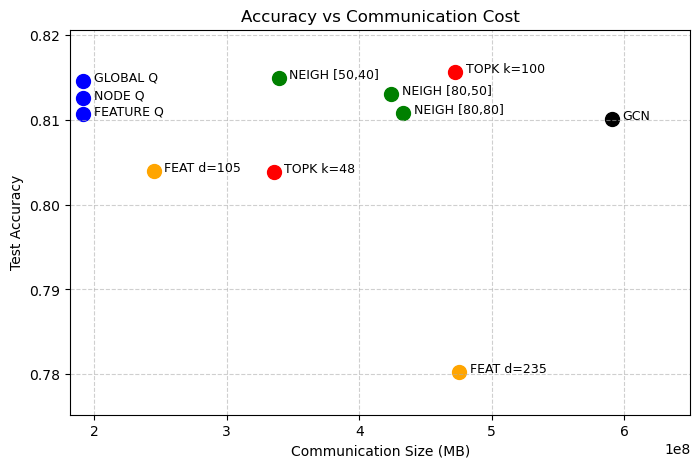

In [ ]:
models = ["GCN", "GLOBAL Q", "FEATURE Q", "NODE Q",
          "NEIGH [80,80]", "NEIGH [80,50]", "NEIGH [50,40]",
          "TOPK k=100", "TOPK k=48",
          "FEAT d=235", "FEAT d=105"]

groups = {"baseline": [0],
    "quant": [1, 2, 3],
    "neigh": [4, 5, 6],
    "topk": [7, 8],
    "feat": [9, 10]}

colors = {"baseline": "black",
    "quant": "blue",
    "neigh": "green",
    "topk": "red",
    "feat": "orange"}

plt.figure(figsize=(8,5))
for group, idxs in groups.items():
    for i in idxs:
        plt.scatter(comm_sizes[i], accuracies[i], s=100,
                    color=colors[group], label=models[i] if i == idxs[0] else "")

x_offset = (max(comm_sizes) - min(comm_sizes)) * 0.02
y_offset = (max(accuracies) - min(accuracies)) * 0.01
for i, (model, x, y) in enumerate(zip(models, comm_sizes, accuracies)):
    plt.text(x + x_offset, y + y_offset, model, ha="left", va="center", fontsize=9)

plt.xlim(min(comm_sizes) * 0.95, max(comm_sizes) * 1.1)
plt.ylim(min(accuracies) - 0.005, max(accuracies) + 0.005)

plt.xlabel("Communication Size (MB)")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs Communication Cost")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()